# QAOA transpilation pipeline

This notebook shows the QAOA transpilation pipeline from the user's perspective. It leverages the `generate_preset_qaoa_pass_manager` provided by the quantum optimization best practices repository.

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

from qiskit_optimization.applications import Maxcut
from qiskit_optimization.translators import to_ising

from qopt_best_practices.circuit_library import annotated_qaoa_ansatz
from qopt_best_practices.transpilation import generate_preset_qaoa_pass_manager

from qiskit.transpiler import Layout
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

### Preamble: backend setup

First, we setup a fake backend with which to work.

In [40]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
backend = GenericBackendV2(
    num_qubits=19, coupling_map=cmap, basis_gates=["x", "sx", "cz", "id", "rz"], seed=0
)

### Optimization problem setup

We now define a simple maximum cut problem for which we want to design a QAOA circuit.

In [41]:
graph = nx.random_regular_graph(n=6, d=3)

mc = Maxcut(graph)
opt_prob = mc.to_quadratic_program()
cost_op, offset = to_ising(opt_prob)

### Creation of QAOA hardware native circuits

We perform the following steps:

1. Define a SWAP strategy for the problem.
2. Remap the problem with the SATMapper.
3. Find a good initial layout
4. Apply a preset QAOA pass manager. This pass manager encapsulates the transpilation steps detailed in other how-to notebooks such as `how_to_apply_optimal_qaoa_transpilation.ipynb`

**1. Define a SWAP strategy**

In [42]:
swap_strat = SwapStrategy.from_line(range(cost_op.num_qubits))
edge_coloring = {(idx, idx + 1): idx % 1 for idx in range(cost_op.num_qubits - 1)}

**2. SAT mapping**

In [43]:
from qopt_best_practices.sat_mapping import SATMapper

sat_cost_op, edge_map, min_k = SATMapper().remap_graph_with_sat(cost_op, swap_strat)

**3. Find a good initial layout**

In [ ]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(ansatz.num_qubits)
initial_layout = Layout.from_intlist(path, ansatz.qregs[0])

Here we plot the result of the SAT mapping and the selected initial_layout on the backend's coupling map.

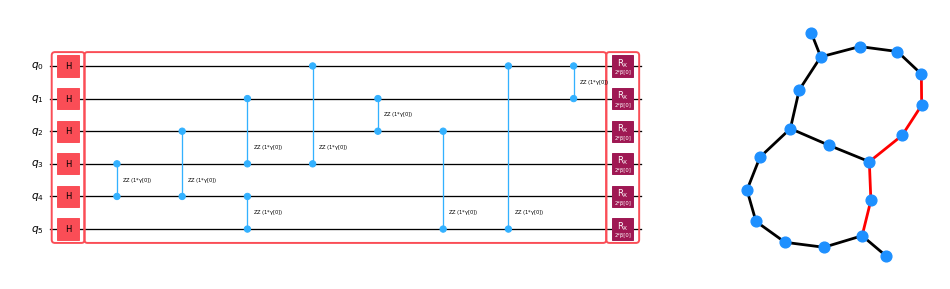

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), gridspec_kw={'width_ratios': [3, 1]})

edge_set = [(path[i], path[i+1]) for i in range(len(path)-1)] + [(path[i+1], path[i]) for i in range(len(path)-1)]
ansatz = annotated_qaoa_ansatz(sat_cost_op, reps=1)
ansatz.draw("mpl", fold=False, ax=axs[0])
cmapg = nx.from_edgelist(list(cmap.get_edges()))
nx.draw(cmapg, ax = axs[1], edge_color=["r" if edge in edge_set else "k" for edge in cmapg.edges()], width=2, node_color="dodgerblue", node_size=60)

**4. Apply a preset QAOA pass manager**

The preset QAOA pass manager applies the swap strategy (using the optional edge coloring) and the initial mapping. In addition it takes care of unrolling the circuit to the basis gate set of the backend and allocating ancillas.

In [22]:
qaoa_pm = generate_preset_qaoa_pass_manager(backend, swap_strat, initial_layout=initial_layout, edge_coloring=edge_coloring)

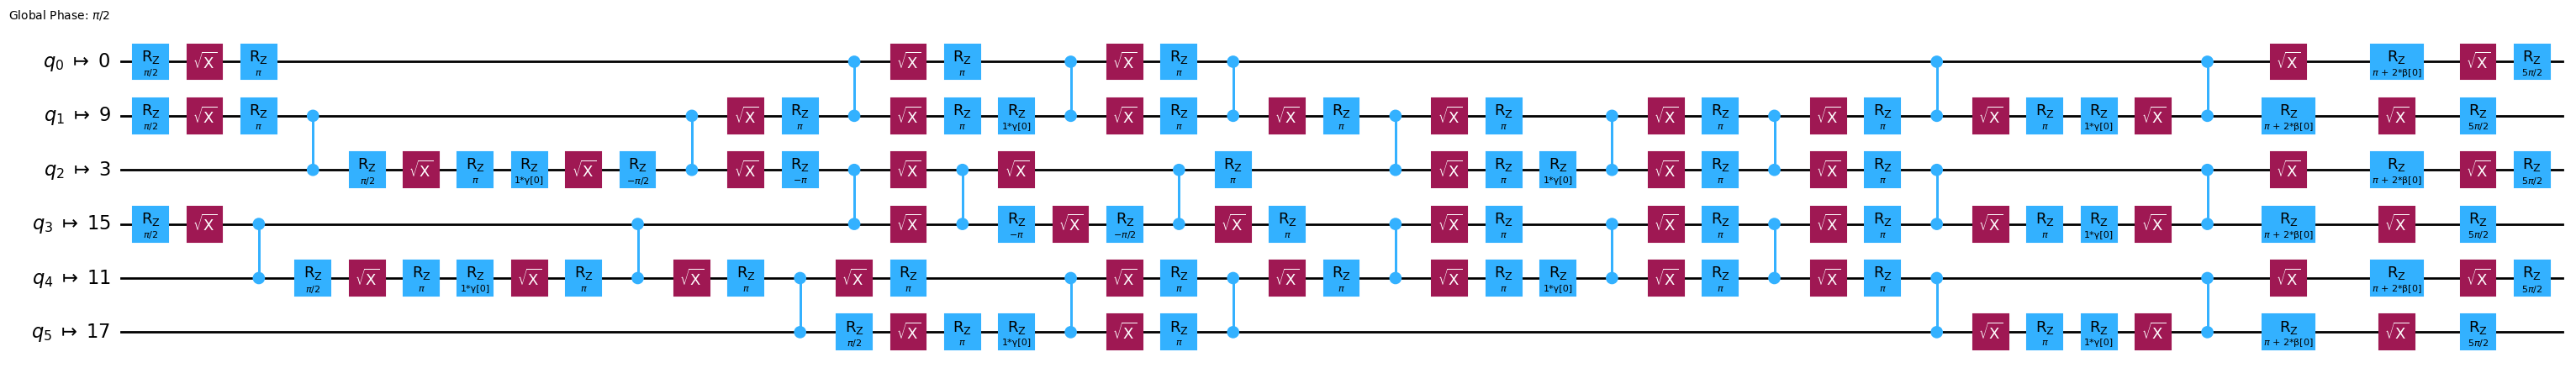

In [23]:
isa_ansatz = qaoa_pm.run(ansatz)
isa_ansatz.draw("mpl", fold=False, wire_order=path + [idx for idx in range(backend.num_qubits) if idx not in path])